In [ ]:
!pip install quantdsl

# Quant DSL Notebook

Welcome to the example Quant DSL example notebook. This is a Jupyter notebook showing how to use Quant DSL.

In the section below, a model of a power plant is defined using Quant DSL. The optionality is modelled
recursively, so that the value of a power plant today is the choice between either running the plant today
and then deciding whether or not to run a hot power plant tomorrow, or not running the power plant today
and then deciding whether or not to run a cooler less efficient power plant tomorrow, and so on until the end.

In [1]:
%%writefile powerplant.py
from quantdsl.semantics import Choice, TimeDelta, Wait, inline


def PowerPlant(start, end, temp):
    if (start < end):
        Wait(start, Choice(
            PowerPlant(Tomorrow(start), end, Hot()) + ProfitFromRunning(start, temp),
            PowerPlant(Tomorrow(start), end, Stopped(temp))
        ))
    else:
        return 0


@inline
def Power(start):
    DayAhead(start, 'POWER')


@inline
def Gas(start):
    DayAhead(start, 'GAS')


@inline
def DayAhead(start, name):
    ForwardMarket(Tomorrow(start), name)

    
@inline
def Tomorrow(start):
    start + TimeDelta('1d')


@inline
def ProfitFromRunning(start, temp):
    if temp == Cold():
        return 0.3 * Power(start) - Gas(start)
    elif temp == Warm():
        return 0.6 * Power(start) - Gas(start)
    else:
        return Power(start) - Gas(start)


@inline
def Stopped(temp):
    if temp == Hot():
        Warm()
    else:
        Cold()


@inline
def Hot():
    2


@inline
def Warm():
    1


@inline
def Cold():
    0

Overwriting powerplant.py


Next, let's model the market in the underlyings. The contract model above involves two markets 'POWER' and 'GAS'.

Below the library's `BlackScholesPriceProcess` is configured for two markets, with volatility `sigma`, correlation coefficients `rho`, and a forward prices `curve`.

In [9]:
gas_and_power = {
    'name': 'quantdsl.priceprocess.blackscholes.BlackScholesPriceProcess',
    'market': ['GAS', 'POWER'],
    'sigma': [0.2, 0.2],
    'rho': [[1.0, 0.8], [0.8, 1.0]],
    'curve': {
        'GAS': [
            ('2011-1-1', 1),
            ('2012-1-1', 13.5),
            ('2012-1-2', 19.4),
            ('2012-1-3', 10.5),
            ('2012-1-4', 10.3),
            ('2012-1-5', 10.1),
            ('2012-1-6', 10.2),
        ],
        'POWER': [
            ('2011-1-1', 11),
            ('2012-1-1', 15.5),
            ('2012-1-2', 14.0),
            ('2012-1-3', 15.0),
            ('2012-1-4', 11.0),
            ('2012-1-5', 1.0),
            ('2012-1-6', 15.0),
        ]
    }
}

Now we can use the quantdsl library's `calc()` function to evaluate the contract model against the market model.

In the Quant DSL expression below, the power plant is modelled over the first twelve days in January 2012, from a cold start. The valuation is observed a year earlier, at the start of January 2011. The interest rate is 2.5%.

In [16]:
from quantdsl import calc

results = calc(
    source_code=("from powerplant import PowerPlant, Cold, Date\n"
                 "PowerPlant(Date('2012-1-1'), Date('2012-1-12'), Cold())"),
    observation_date='2011-11-1',
    interest_rate=12.5,
    periodisation='daily',
    price_process=gas_and_power,
    verbose=True
)

Compiled 79 nodes 
Compilation in 0.752s
Simulation in 0.140s
Starting 1267 node evaluations, please wait...
1267/1267 100.00% complete 116.07 eval/s running 11s eta 0s     
Evaluation in 10.916s


Because the `periodisation` argument of `calc` was used, so there are some "periods", and the results can be plotted using `results.plot()`.

In this example, the simulated gas and power prices are displayed, with confidence intervals reflecting the diffusion of the prices in the simulation.

The delta hedges are shown, which reflect the optimal dispatch decisions. Uncertainty in the decisions is reflected in the asymmetric confidence intervals.

Finally, the cumulative cash from the hedge positions (discounted to the observation date) is polotted in green.

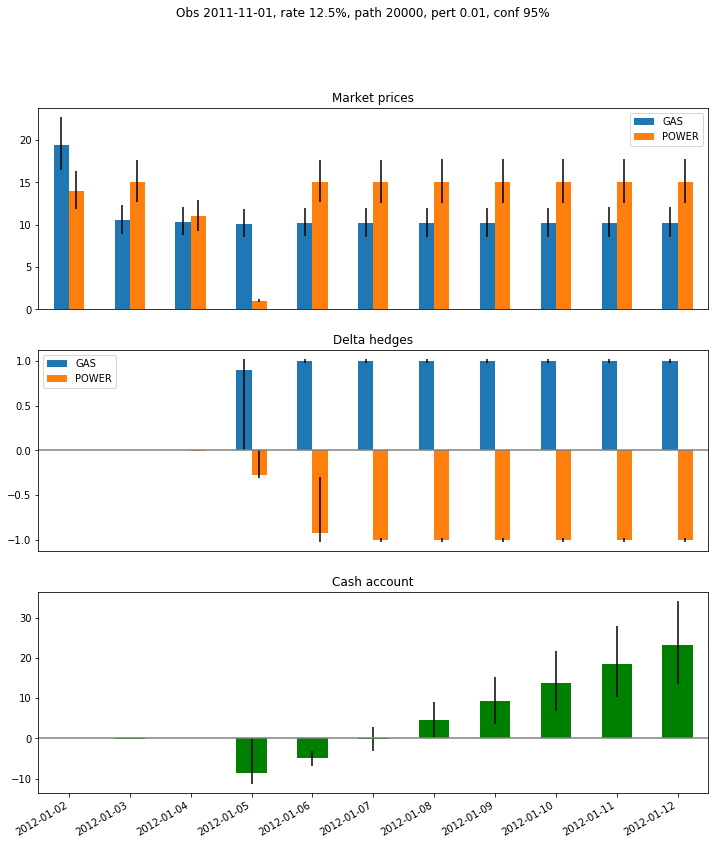

In [17]:
results.plot(
    confidence_interval=95,
    figsize=(12, 14)
)

The results can be printed to show month-by-month data plotted above. The fair value, produced directly by the model before the deltas are calculated, is printed last.

In [15]:
print(results)



2012-01-02 GAS
Price:    19.40
Delta:    -0.01
Hedge:     0.01 ± 0.00
Cash:     -0.21 ± 0.04

2012-01-02 POWER
Price:    13.99
Delta:     0.00
Hedge:    -0.00 ± 0.00
Cash:      0.06 ± 0.02

2012-01-03 GAS
Price:    10.50
Delta:    -0.10
Hedge:     0.12 ± 0.00
Cash:     -0.95 ± 0.07

2012-01-03 POWER
Price:    14.99
Delta:     0.04
Hedge:    -0.04 ± 0.00
Cash:      0.66 ± 0.06

2012-01-04 GAS
Price:    10.30
Delta:    -0.10
Hedge:     0.11 ± 0.00
Cash:     -0.92 ± 0.06

2012-01-04 POWER
Price:    10.99
Delta:     0.10
Hedge:    -0.11 ± 0.00
Cash:      1.22 ± 0.08

2012-01-05 GAS
Price:    10.10
Delta:    -0.51
Hedge:     0.58 ± 0.00
Cash:     -5.11 ± 0.10

2012-01-05 POWER
Price:     1.00
Delta:     0.15
Hedge:    -0.17 ± 0.00
Cash:      0.16 ± 0.01

2012-01-06 GAS
Price:    10.20
Delta:    -0.86
Hedge:     0.98 ± 0.00
Cash:     -8.79 ± 0.07

2012-01-06 POWER
Price:    14.99
Delta:     0.65
Hedge:    -0.74 ± 0.00
Cash:      9.88 ± 0.12

2012-01-07 GAS
Price:    10.20
Delta:    -0.87
H

The contract deltas are calculated by perturbing the underlying values and revaluing the contract. The hedge positions are calculated to obtain risk neutral positions in each period.
Hedges are forward contracts, and since the delta of a forward contract is the discount rate, so the hedge quantities are slightly different from the contract deltas when interest rates are non-zero.
The cash from the hedges is hedge quantity multiplied by the price, and that value is discounted from the period to the observation date. These discounted cash values are summed to give the
net cash from hedges.